In [227]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
import scipy.stats as scs
from scipy.stats import norm
from pathlib import Path
from scipy.sparse import csr_matrix
import math
import matplotlib.pyplot as plt


In [149]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [170]:
# -------- Insert your code here -------- #
filename_save_out = "filename_save_out"
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios

    # -------- Insert your code here -------- #
    # Generate dependent variable: correlated normal systemic risk
    np.random.seed(42)
    # system risk is Nout * number of credit driver
    # system risk is identical across all counterparties, but 
    Z_sys = np.random.normal(0, 1, (Nout, rho.shape[0])) 
    # Apply Cholesky decomposition for correlation
    Y_sys = Z_sys @ sqrt_rho.T 

    # Generate independent variable: idiosyncratic risk
    Z_idio = np.random.normal(0, 1, (Nout, K))  

    # Combine systemic and idiosyncratic risks
    sigma = np.sqrt(1 - beta**2)
    # driver index from 1
    W = beta * Y_sys[:, driver.astype(int)-1] + sigma * Z_idio


    ###### Calculate credit state ######
    credit_state = np.sum(W[:, :, np.newaxis] > CS_Bdry[np.newaxis, :, :], axis=2) + 1 

    ###### Credit state to Loss Out ######
    Losses_out = np.zeros((Nout, K))
    for k in range(K):
        #for each credit state in column k, find the correct exposure under row k
        exposure_k = exposure[k, credit_state[:, k] - 1] #This is LOSS rather than exposure
        # print(exp_k)
        #loss_k = value[k] - exposure_k  # Loss per counterparty
        Losses_out[:, k] = exposure_k

print("Losses_out matrix:")
print(Losses_out)
Losses_out = csr_matrix(Losses_out)

# print(np.min(W))
# print(np.min(credit_state))
# unique, counts = np.unique(credit_state, return_counts=True)
# print(unique, " ", counts)

# print(np.sum(Losses_out < 0), " greater than zero: ", np.sum(Losses_out > 0))


(100000, 50)
Losses_out matrix:
[[     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]
 [ 11484.      0.      0. ... 170311.      0.      0.]
 ...
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.  56464.]]


## Out-of-Sample : Compute VaR and CVaR

In [151]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out.toarray(), rowvar=False) # Losses_out as a sparse matrix
# print(var_l.shape)

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)


# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))


In [252]:
print("True distribution - Mean of each bond:\n",mu_l)
print("True distribution - Variance of each bond:\n",mu_l)

True distribution - Mean of each bond:
 [[1.88587207e+03 3.22791589e+03 1.03516508e+04 2.67234644e+05
  7.49915495e+03 5.26435236e+03 1.19433688e+04 9.57220372e+02
  6.89706833e+02 1.53450502e+05 1.01791951e+04 3.75803827e+04
  8.66116969e+02 2.92991463e+03 1.96099442e+03 1.02557283e+03
  6.40077599e+04 5.18454192e+04 8.12490324e+03 3.71860485e+03
  1.39434576e+03 1.78367315e+02 3.22028287e+03 1.54495065e+03
  5.88946800e+01 9.13480414e+01 3.15031027e+04 6.88225380e+03
  2.00161355e+04 6.16416807e+03 1.66822744e+03 1.18825211e+04
  2.68548926e+04 1.83087274e+06 6.85991577e+03 1.28494926e+03
  1.68996033e+02 9.83839185e+02 1.19741234e+03 3.66120927e+04
  3.49493173e+02 3.08240562e+04 9.52324482e+02 1.51287005e+04
  5.25815806e+03 3.16049891e+03 8.43355873e+04 5.32855281e+03
  2.73948712e+03 3.10482520e+02 3.25372037e+03 1.94848713e+05
  2.43527130e+04 6.66193807e+03 5.26711640e+05 3.14279402e+03
  1.11301915e+05 2.41895488e+04 2.13058505e+03 4.17209646e+04
  1.75498978e+03 1.22787134e+0

In [158]:

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #
        
        #Losses_out is 100000*100 and x0[portN] is 100*1 
        Losses_port = np.sort(Losses_out @ x0[portN])       

        VaRout[portN, q] = Losses_port[int(math.ceil(Nout * alf)) - 1]
        VaRinN[portN, q] = np.mean(Losses_port) + scs.norm.ppf(alf) * np.std(Losses_port)
        CVaRout[portN, q] = (1 / (Nout * (1 - alf))) * ((math.ceil(Nout * alf) - Nout * alf) * VaRout[portN, q] + sum(Losses_port[int(math.ceil(Nout * alf)):]))
        CVaRinN[portN, q] = np.mean(Losses_port) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(Losses_port)
print("VaRout:", VaRout)
print("CVaRout:", CVaRout)

VaRout: [[37282631.02       54519973.36000001]
 [27420869.74348778 41440595.66747013]]
CVaRout: [[45038705.41803996 62980086.24459998]
 [33729733.8562785  48613020.30341443]]


## Monte Carlo approximation

In [259]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}
PorfMC1_mean = {}
PorfMC2_mean = {}
PorfMC1_std = {}
PorfMC2_std = {}

for portN in range(2):
    PorfMC1_mean[portN] = np.zeros(N_trials)
    PorfMC2_mean[portN] = np.zeros(N_trials)
    PorfMC1_std[portN] = np.zeros(N_trials)
    PorfMC2_std[portN] = np.zeros(N_trials)
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

In [260]:



for tr in range(1, N_trials + 1):
    ########### Monte Carlo approximation 1 ###########

    # -------- Insert your code here -------- #

    Z_sys = np.random.normal(0, 1, (np.int32(np.ceil(Nin / Ns)), rho.shape[0]))
    # Apply Cholesky decomposition for correlation
    # 5 idiosyncratic scenarios for each systemic
    # Repeat 5 times each row -> 5000*50, 
    Y_sys = np.repeat(Z_sys @ sqrt_rho.T , repeats=5, axis=0) 

    # Generate independent variable: idiosyncratic risk
    # Z_idio size 5000*100
    Z_idio = np.random.normal(0, 1, (Nin, K))

    # Combine systemic and idiosyncratic risks
    sigma = np.sqrt(1 - beta**2)

    # driver index from 1
    W = beta * Y_sys[:, driver.astype(int)-1] + sigma * Z_idio

    ###### Calculate credit state ######
    credit_state = np.sum(W[:, :, np.newaxis] > CS_Bdry[np.newaxis, :, :], axis=2) + 1 
    # print(credit_state.shape)

    ###### Credit state to Loss Out ######
    Losses_inMC1 = np.zeros((Nin, K))
    for k in range(K):
        #for each credit state in column k, find the correct exposure under row k
        exposure_k = exposure[k, credit_state[:, k] - 1] #This is LOSS rather than exposure
        # print(exp_k)
        #loss_k = value[k] - exposure_k  # Loss per counterparty
        Losses_inMC1[:, k] = exposure_k

    Losses_inMC1 = csr_matrix(Losses_inMC1)


    ############     Monte Carlo approximation 2 ###########

    #     -------- Insert your code here -------- #

    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2
    # Apply Cholesky decomposition for correlation
    Y_sys = np.random.normal(0, 1, (Nin, rho.shape[0])) @ sqrt_rho.T

    # Generate independent variable: idiosyncratic risk
    # Z_idio size 5000*100
    Z_idio = np.random.normal(0, 1, (Nin, K))

    # Combine systemic and idiosyncratic risks
    sigma = np.sqrt(1 - beta**2)

    # driver index from 1
    W = beta * Y_sys[:, driver.astype(int)-1] + sigma * Z_idio

    ###### Calculate credit state ######
    credit_state = np.sum(W[:, :, np.newaxis] > CS_Bdry[np.newaxis, :, :], axis=2) + 1 
    # print(credit_state.shape)

    ###### Credit state to Loss Out ######
    Losses_inMC2 = np.zeros((Nin, K))
    for k in range(K):
        #for each credit state in column k, find the correct exposure under row k
        exposure_k = exposure[k, credit_state[:, k] - 1] #This is LOSS rather than exposure
        # print(exp_k)
        #loss_k = value[k] - exposure_k  # Loss per counterparty
        Losses_inMC2[:, k] = exposure_k

    # print("Losses_inMC2 with shape", Losses_inMC2.shape,":")
    # print(Losses_inMC2)
    Losses_inMC2 = csr_matrix(Losses_inMC2)


    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss           
            portf_loss_inMC1 = np.sort(Losses_inMC1 @ x0[portN])  
            portf_loss_inMC2 = np.sort(Losses_inMC2 @ x0[portN]) 

            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1.toarray(), rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2.toarray(), rowvar=False)

            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial

            mu_p_MC1 = np.mean(portf_loss_inMC1)
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = np.mean(portf_loss_inMC2)
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            
            PorfMC1_mean[portN][tr - 1]  = mu_p_MC1
            PorfMC2_mean[portN][tr - 1]  = mu_p_MC2
            PorfMC1_std[portN][tr - 1]  = sigma_p_MC1
            PorfMC2_std[portN][tr - 1]  = sigma_p_MC2

            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) - 1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) - 1]
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2

            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC1[portN, q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin * alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC2[portN, q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin * alf)):]))
            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(portf_loss_inMC1)
            CVaRinN2[portN, q][tr - 1] =  mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(portf_loss_inMC2)


In [261]:

# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $37282631.02, CVaR 99.0% = $45038705.42
In-sample MC1: VaR 99.0% = $37199183.26, CVaR 99.0% = $44573729.30
In-sample MC2: VaR 99.0% = $37185325.95, CVaR 99.0% = $44550141.17
In-sample No: VaR 99.0% = $26162490.95, CVaR 99.0% = $29053311.75
In-sample N1: VaR 99.0% = $26231617.31, CVaR 99.0% = $29123024.33
In-sample N2: VaR 99.0% = $26182559.60, CVaR 99.0% = $29069417.23

Out-of-sample: VaR 99.9% = $54519973.36, CVaR 99.9% = $62980086.24
In-sample MC1: VaR 99.9% = $53667406.01, CVaR 99.9% = $60367350.91
In-sample MC2: VaR 99.9% = $53614630.41, CVaR 99.9% = $60711359.62
In-sample No: VaR 99.9% = $32679080.84, CVaR 99.9% = $35040915.27
In-sample N1: VaR 99.9% = $32749528.68, CVaR 99.9% = $35111842.05
In-sample N2: VaR 99.9% = $32690215.57, CVaR 99.9% = $35048812.04


Portfolio 2:

Out-of-sample: VaR 99.0% = $27420869.74, CVaR 99.0% = $33729733.86
In-sample MC1: VaR 99.0% = $27436853.28, CVaR 99.0% = $33238940.71
In-sample MC2: VaR 99.0% = $27292814

In [297]:
#Display Mean and std
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    print('Out-of-sample: Mean = ', np.mean(Losses_out @ x0[portN]), ' Std = ', np.std(Losses_out @ x0[portN]))
    print('In-sample MC1 average of 100 trials: Mean = ', np.mean(PorfMC1_mean[portN]), ' Std = ', np.mean(PorfMC1_std[portN]))
    print('In-sample MC2 average of 100 trials: Mean = ', np.mean(PorfMC2_mean[portN]), ' Std = ', np.mean(PorfMC2_std[portN]))



# Plot results (6 plots, 2 portfolios & 3 scenarios)
# # Figure (1):
# # -------- Insert your code here -------- #
# # Figure (2):
# # -------- Insert your code here -------- #
# # Build tables for errors
# # MC  approximations (16 rows)
# df_mc = pd.DataFrame({})
# # -------- Insert your code here -------- #
# # Normal approximations (16 rows)
# df_N = pd.DataFrame({})
# # -------- Insert your code here -------- #



Portfolio 1:

Out-of-sample: Mean =  6316746.7493652  Std =  8530858.356532618
In-sample MC1 average of 100 trials: Mean =  6381848.654341359  Std =  8532588.300593285
In-sample MC2 average of 100 trials: Mean =  6364022.93721756  Std =  8519162.971568126

Portfolio 2:

Out-of-sample: Mean =  6208613.948005141  Std =  6395939.466982296
In-sample MC1 average of 100 trials: Mean =  6240744.568389106  Std =  6367128.867495955
In-sample MC2 average of 100 trials: Mean =  6234299.158832099  Std =  6385510.8296006145


In [235]:
def plot_result(s, VaR_99, VaRn_99, VaR_999,VaRn_999, porf_name):
    #from posixpath import normpath
    fig = plt.figure(figsize=(20,10))
    mu, sigma = np.mean(s), np.std(s) # mean and standard deviation
    count, bins, ignored = plt.hist(s, 100, density=True) # In your plot, you need to use Loss * X0[] to replace s
    # Plot the Normal curve
    norm = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))
    norm = norm * sum(count) / sum(norm)
    #Normal Distribution curve
    plt.plot(bins, norm, linewidth=2, color='r')
    # VaR red line
    # [0,max(count)/2]: height of VaR line
    plt.plot([VaR_99,VaR_99],[0,max(count)/2],color='r',linewidth=1,linestyle='-.')
    plt.plot([VaRn_99,VaRn_99],[0,max(count)/2],color='r',linewidth=1,linestyle='-.')
    plt.text(0.98*VaR_99, max(count)/1.9, '__ VaR 99%',fontsize=8, rotation=45)
    plt.text(0.98*VaRn_99, max(count)/1.9, '__ VaRn 99%',fontsize=8, rotation=45)
    
    plt.plot([VaR_999,VaR_999],[0,max(count)/2],color='r',linewidth=1,linestyle='-.')
    plt.plot([VaRn_999,VaRn_999],[0,max(count)/2],color='r',linewidth=1,linestyle='-.')
    plt.text(0.98*VaR_999, max(count)/1.9, '__ VaR 99.9%',fontsize=8, rotation=45)
    plt.text(0.98*VaRn_999, max(count)/1.9, '__ VaRn 99.9%',fontsize=8, rotation=45)
    """
    Note: This is just a very simple example, the graph required for this assignment should be like tutorial slide
    - Plot Distribution example page
    """
    plt.xlabel('Loss in portfolio',fontsize=12)
    plt.ylabel('Frequency',fontsize=12)
    plt.title(porf_name,fontsize=16)
    plt.show()
    

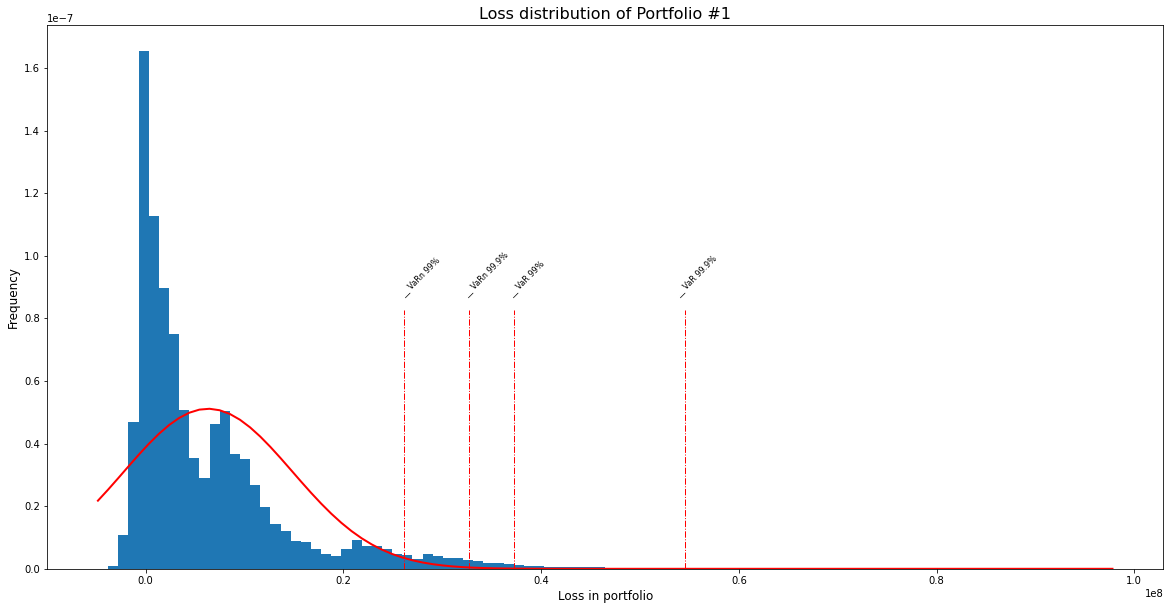

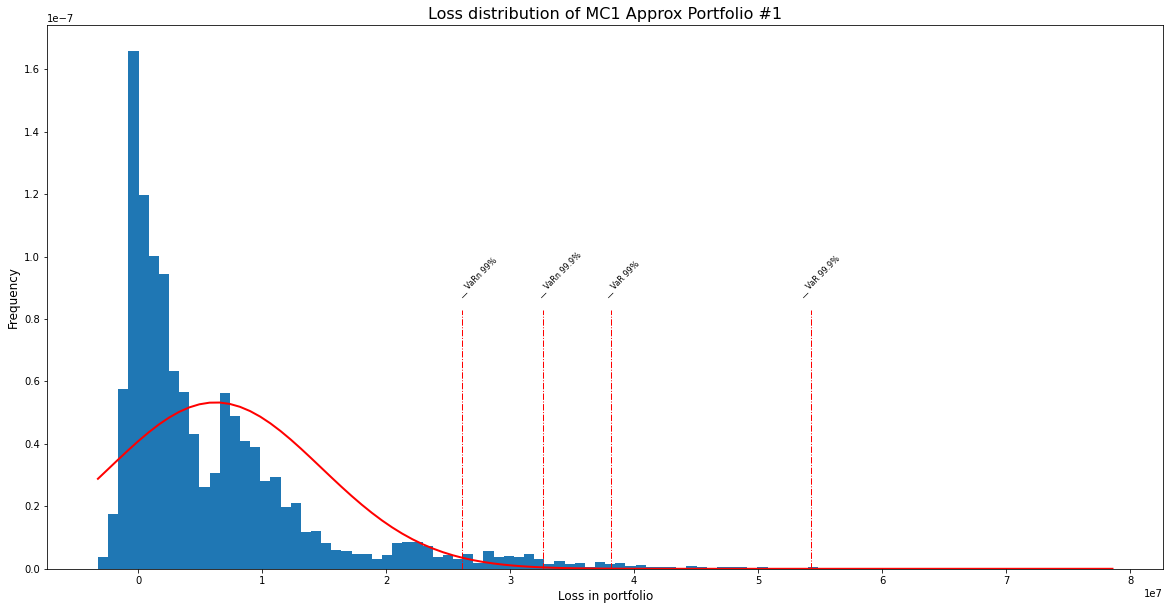

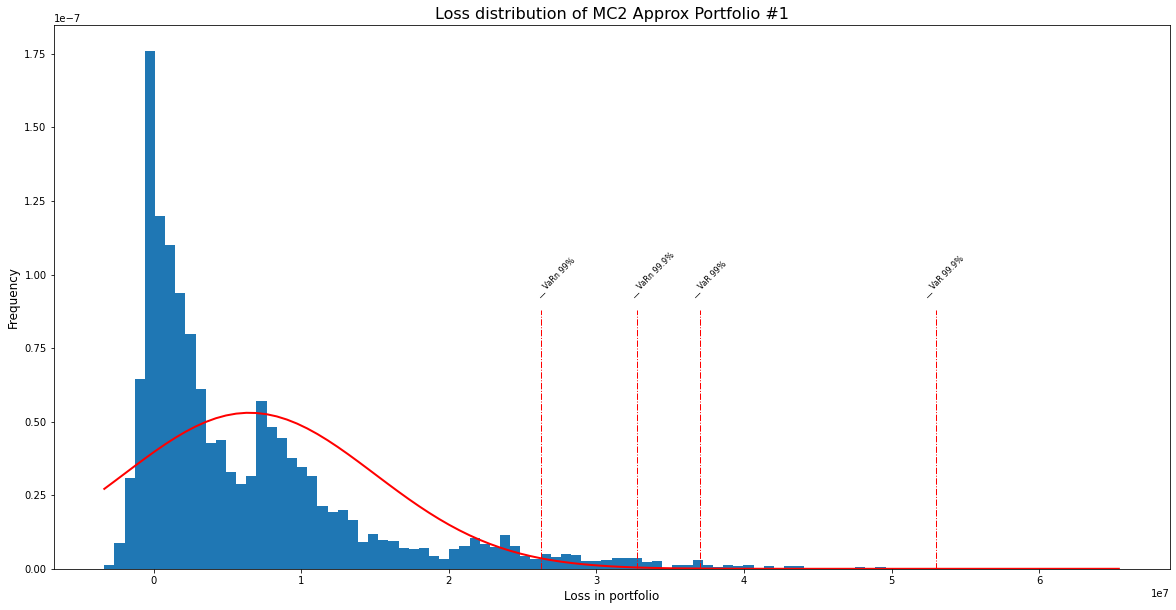

In [306]:
plot_result(Losses_out @ x0[0], VaRout[0, 0], VaRinN[0,0], VaRout[0, 1], VaRinN[0,1], "Loss distribution of Portfolio #1")

#MC1
plot_result(Losses_inMC1 @ x0[0], VaRinMC1[0, 0][99], VaRinN1[0, 0][99],VaRinMC1[0, 1][99], VaRinN1[0, 1][99], "Loss distribution of MC1 Approx Portfolio #1")

#MC2
plot_result(Losses_inMC2 @ x0[0], VaRinMC2[0, 0][99], VaRinN2[0, 0][99],VaRinMC2[0, 1][99], VaRinN2[0, 1][99], "Loss distribution of MC2 Approx Portfolio #1")


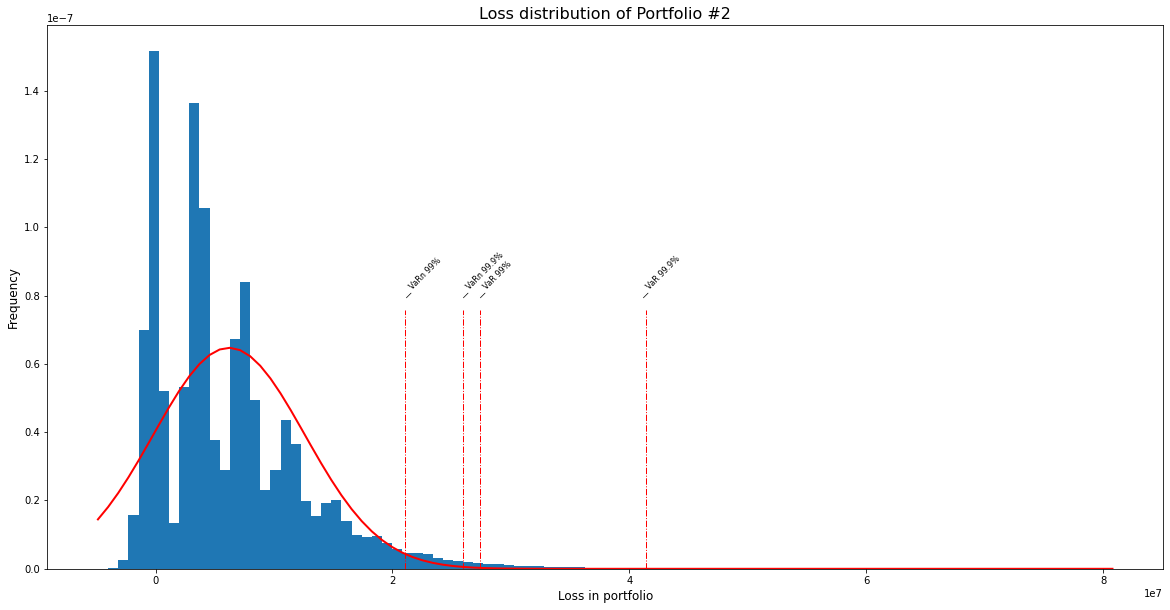

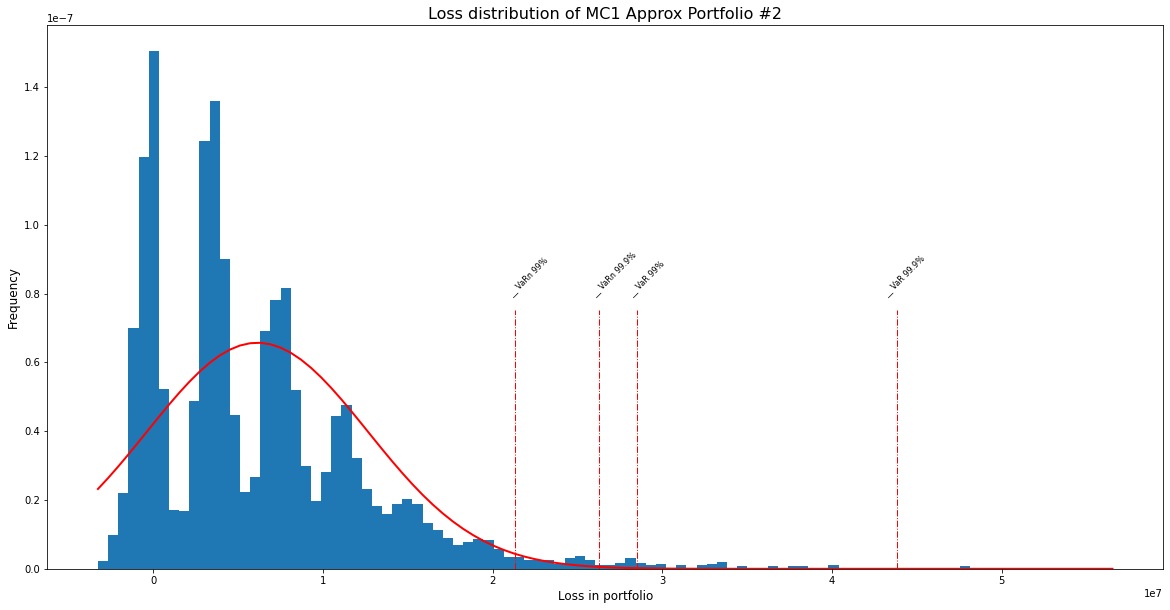

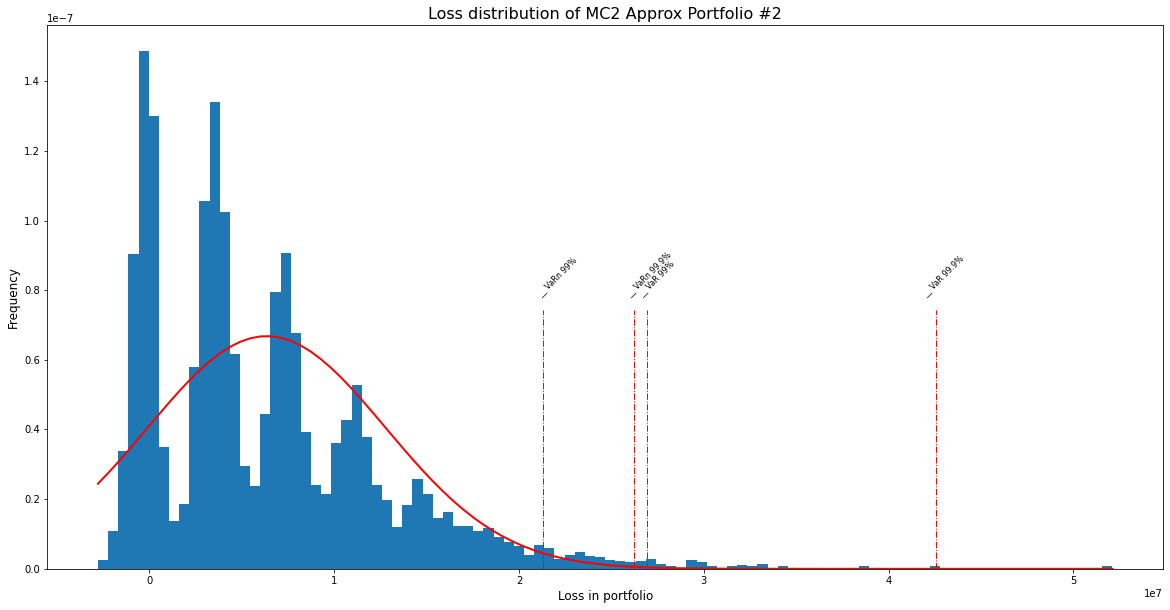

In [304]:
plot_result(Losses_out @ x0[1], VaRout[1, 0], VaRinN[1,0], VaRout[1, 1], VaRinN[1,1], "Loss distribution of Portfolio #2")

#MC1
plot_result(Losses_inMC1 @ x0[1], VaRinMC1[1, 0][99], VaRinN1[1, 0][99],VaRinMC1[1, 1][99], VaRinN1[1, 1][99], "Loss distribution of MC1 Approx Portfolio #2")

#MC2
plot_result(Losses_inMC2 @ x0[1], VaRinMC2[1, 0][99], VaRinN2[1, 0][99],VaRinMC2[1, 1][99], VaRinN2[1, 1][99], "Loss distribution of MC2 Approx Portfolio #2")



## Sampling Error and Model Error
 sampling error = Z * sigma / sqrt(n) where Z is score value based on confidence interval.
 sigma is population standard deviation. n is the size of sample.

In [307]:
def calculate_sampling_error(sample, n):
    z_score = norm.ppf(0.975) # approx 1.96 for 95% CI
    sigma = np.std(sample)
    return z_score * (sigma / np.sqrt(n))
     
    
z_score = norm.ppf(0.975)
data = {
    "Out-of-Sample": [calculate_sampling_error(Losses_out @ x0[0], Nout), calculate_sampling_error(Losses_out @ x0[1], Nout)],
    "MC1": [z_score * (np.mean(PorfMC1_std[0]) / np.sqrt(Nin)), z_score * (np.mean(PorfMC1_std[1]) / np.sqrt(Nin))],
#     "MC1": [z_score * (PorfMC1_std[0][99] / np.sqrt(Nin)), z_score * (PorfMC1_std[1][99]/ np.sqrt(Nin))],
    "MC2": [z_score * (np.mean(PorfMC2_std[0]) / np.sqrt(Nin)), z_score * (np.mean(PorfMC2_std[1]) / np.sqrt(Nin))],
#     "MC2": [z_score * (PorfMC2_std[0][99] / np.sqrt(Nin)), z_score * (PorfMC2_std[1][99]/ np.sqrt(Nin))],
}

sampling_error = pd.DataFrame(data, index=["Portfolio 1", "Portfolio 2"])
sampling_error

,Out-of-Sample,MC1,MC2
Portfolio 1,52873.836307,236506.935148,236134.810851
Portfolio 2,39641.715086,176484.564952,176994.077583


In [308]:
#Portfolio 1
data = {
    "VaR 99%": [np.abs(VaRout[0, 0] - VaRinN[0, 0]),
                np.abs(np.mean(VaRinN1[0, 0])-np.mean(VaRinMC1[0, 0])), 
                np.abs(np.mean(VaRinN2[0, 0])-np.mean(VaRinMC2[0, 0]))],
    "VaR 99.9%": [np.abs(VaRout[0, 1] - VaRinN[0, 1]),
                np.abs(np.mean(VaRinN1[0, 1])-np.mean(VaRinMC1[0, 1])), 
                np.abs(np.mean(VaRinN2[0, 1])-np.mean(VaRinMC2[0, 1]))],
    "CVaR 99%": [np.abs(CVaRout[0, 0] - CVaRinN[0, 0]),
                np.abs(np.mean(CVaRinN1[0, 0])-np.mean(CVaRinMC1[0, 0])), 
                np.abs(np.mean(CVaRinN2[0, 0])-np.mean(CVaRinMC2[0, 0]))],
    "CVaR 99.9%": [np.abs(CVaRout[0, 1] - CVaRinN[0, 1]),
                np.abs(np.mean(CVaRinN1[0, 1])-np.mean(CVaRinMC1[0, 1])), 
                np.abs(np.mean(CVaRinN2[0, 1])-np.mean(CVaRinMC2[0, 1]))],
}

model_error = pd.DataFrame(data, index=["True","MonteCarlo1", "MonteCarlo2"])
model_error

,VaR 99%,VaR 99.9%,CVaR 99%,CVaR 99.9%
True,1.112014e+07,2.184089e+07,1.598539e+07,2.793917e+07
MonteCarlo1,1.096757e+07,2.091788e+07,1.545070e+07,2.525551e+07
MonteCarlo2,1.100277e+07,2.092441e+07,1.548072e+07,2.566255e+07


In [309]:
#Portfolio 2
data = {
    "VaR 99%": [np.abs(VaRout[1, 0] - VaRinN[1, 0]),
                np.abs(np.mean(VaRinN1[1, 0])-np.mean(VaRinMC1[1, 0])), 
                np.abs(np.mean(VaRinN2[1, 0])-np.mean(VaRinMC2[1, 0]))],
    "VaR 99.9%": [np.abs(VaRout[1, 1] - VaRinN[1, 1]),
                np.abs(np.mean(VaRinN1[1, 1])-np.mean(VaRinMC1[1, 1])), 
                np.abs(np.mean(VaRinN2[1, 1])-np.mean(VaRinMC2[1, 1]))],
    "CVaR 99%": [np.abs(CVaRout[1, 0] - CVaRinN[1, 0]),
                np.abs(np.mean(CVaRinN1[1, 0])-np.mean(CVaRinMC1[1, 0])), 
                np.abs(np.mean(CVaRinN2[1, 0])-np.mean(CVaRinMC2[1, 0]))],
    "CVaR 99.9%": [np.abs(CVaRout[1, 1] - CVaRinN[1, 1]),
                np.abs(np.mean(CVaRinN1[1, 1])-np.mean(CVaRinMC1[1, 1])), 
                np.abs(np.mean(CVaRinN2[1, 1])-np.mean(CVaRinMC2[1, 1]))],
}

model_error = pd.DataFrame(data, index=["True","MonteCarlo1", "MonteCarlo2"])
model_error

,VaR 99%,VaR 99.9%,CVaR 99%,CVaR 99.9%
True,6.333076e+06,1.546704e+07,1.047457e+07,2.086870e+07
MonteCarlo1,6.383952e+06,1.463039e+07,1.002843e+07,1.806804e+07
MonteCarlo2,6.203596e+06,1.487200e+07,1.016902e+07,1.977378e+07
